In [1]:
import torch
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import squidpy as sq
from torch.utils.data import DataLoader, Dataset
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
import os
import sys
import re
plt.style.use('default')
%load_ext autoreload 
%autoreload 2

/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c106detail14torchCheckFailEPKcS2_jRKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN3c106detail14torchCheckFailEPKcS2_jRKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warnings.warn(
/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/torch_geometric/typing.py:124:

In [73]:
sim_adata = sc.read_h5ad('/home/DingchengYi/BulkPheno/data/Simulation/sim1.h5ad')
sim_adata

AnnData object with n_obs × n_vars = 2000 × 500
    obs: 'Cell', 'Group', 'ExpLibSize', 'sizeFactor'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3'
    obsm: 'X_pca', 'X_umap'

In [22]:
points_short = np.random.uniform(0, 1, size=(2000, 2))
dis_mat = np.linalg.norm(points_short[:, np.newaxis, :] - points_short[np.newaxis, :, :], axis=2)
np.fill_diagonal(dis_mat, 1)
sparse_mat = scipy.sparse.coo_matrix(dis_mat < 0.05)
row, col = sparse_mat.nonzero()
remain_points = [x for x in range(2000) if x not in col]
remain_points
# points_short = points_short[remain_points]
# points_short


[]

In [30]:
def generate_and_filter_points(n_initial_points=1500, n_final_points=1000, min_distance=0.005):
    """
    生成 n_initial_points 个随机点，然后过滤掉距离小于 min_distance 的点，
    直到剩余 n_final_points 个点。

    Args:
        n_initial_points: 初始生成的点的数量。
        n_final_points: 最终需要的点的数量。
        min_distance: 任意两点之间的最小距离。

    Returns:
        一个 NumPy 数组，形状为 (n_final_points, 2)，其中每一行代表一个点的坐标。
    """

    points = np.random.uniform(0, 1, size=(n_initial_points, 2))

    while len(points) > n_final_points:
        # 计算距离矩阵
        distances = np.linalg.norm(points[:, np.newaxis, :] - points[np.newaxis, :, :], axis=2)

        # 将对角线上的距离设置为无穷大，避免点和自身比较
        np.fill_diagonal(distances, np.inf)

        # 找到距离最近的两个点的索引
        min_distance_index = np.argmin(distances)
        i = min_distance_index // len(points)
        j = min_distance_index % len(points)

        # 如果最近距离小于 min_distance，则移除其中一个点（这里移除索引较大的点）
        if distances[i, j] < min_distance:
            points = np.delete(points, max(i, j), axis=0)
        else:
            # 如果所有点都满足最小距离要求，则提前结束循环
            break

    # 如果剩余的点数多于 n_final_points，则随机选择 n_final_points 个点
    if len(points) > n_final_points:
        indices = np.random.choice(len(points), size=n_final_points, replace=False)
        points = points[indices]

    return points
n_final_points = 1000
min_distance = 0.005
points = generate_and_filter_points(n_final_points=n_final_points, min_distance=min_distance)


In [42]:
adata = sc.read_h5ad('/home/DingchengYi/BulkPheno/data/TNBC_adata/NTImg0019.h5ad')
adata.obsm['spatial'].max(axis=0), adata.obsm['spatial'].min(axis=0), adata.obsm['spatial'].shape

(array([497.21052632, 497.68571429]),
 array([1.75      , 2.39393939]),
 (1106, 2))

In [79]:
sim_adata.obs['Group'].value_counts()

Group
Group1    798
Group3    106
Group2     96
Name: count, dtype: int64

In [83]:
points[(points[:, 0] > 0.6) & (points[:, 1] > 0.6)]

array([[0.79919332, 0.84191883],
       [0.69186493, 0.73210074],
       [0.63280922, 0.63422545],
       [0.92927037, 0.86847151],
       [0.81892086, 0.79382512],
       [0.83825818, 0.82665798],
       [0.75818652, 0.61471931],
       [0.94934913, 0.64967882],
       [0.71279292, 0.98642474],
       [0.65723016, 0.99617266],
       [0.81947036, 0.70697986],
       [0.65902889, 0.79048689],
       [0.74546586, 0.75715968],
       [0.85683075, 0.83301681],
       [0.79547032, 0.6124589 ],
       [0.89069009, 0.85839429],
       [0.87685203, 0.75212099],
       [0.94706968, 0.8644957 ],
       [0.78556889, 0.73747488],
       [0.8306349 , 0.96935844],
       [0.77841759, 0.85958389],
       [0.83521055, 0.7596037 ],
       [0.79263945, 0.98307313],
       [0.9713029 , 0.73827304],
       [0.91106178, 0.96630816],
       [0.68407737, 0.74599242],
       [0.90798453, 0.75129116],
       [0.68501179, 0.91909318],
       [0.76405928, 0.75984598],
       [0.65712514, 0.82323593],
       [0.

In [72]:
# group2_id = np.argwhere((points[:, 0] < 0.25) & (points[:, 1] < 0.25)).reshape(-1)
# group3_id = np.argwhere((points[:, 0] < 0.45) & (points[:, 1] < 0.45)).reshape(-1)
group23_id = np.argwhere((points[:, 0] > 0.3) & (points[:, 1] > 0.3) & (points[:, 0] < 0.7) & (points[:, 1] < 0.7)).reshape(-1)
# len(group2_id)
group2_id = np.random.choice(group23_id, 100, replace=False)
group3_id = []
# group3_id = np.array([x for x in group23_id if x not in group2_id])
# group3_id = np.random.choice(group3_id, 40)
# group3_id = np.argwhere((points[:, 0] < 0.5)).reshape(-1)
# group3_id = np.random.choice(group3_id, 100)
# group3_id = np.array([x for x in group3_id if x not in group2_id])
# group1_id = set(range(n_final_points)) - set(group2_id) - set(group3_id)
group1_id = set(range(n_final_points)) - set(group2_id)
group1_id = np.array(list(group1_id))
print(len(group1_id), len(group3_id), len(group2_id))
# print(group1_id, group2_id)
# total_id = np.concatenate([group1_id, group3_id, group2_id])
total_id = np.concatenate([group1_id, group2_id])
points = points[total_id]

901 0 100


In [74]:
sim_adata=sim_adata[sim_adata.obs.sort_values('Group').index]

In [ ]:
np.random.choice

array([0.13054571, 0.73034402, 0.91274719, 0.49854331, 0.59735631,
       0.0268063 , 0.82718085, 0.2960412 , 0.43270327, 0.54381422])

In [75]:
group_1_cell = np.random.choice(sim_adata.obs.query('Group == "Group1"')['Cell'].values, len(group1_id), replace=False)
group_2_cell = np.random.choice(sim_adata.obs.query('Group == "Group2"')['Cell'].values, len(group2_id), replace=False)
group_3_cell = np.random.choice(sim_adata.obs.query('Group == "Group3"')['Cell'].values, len(group3_id), replace=False)
all_cells = np.concatenate([group_1_cell, group_3_cell, group_2_cell])
sim_adata = sim_adata[all_cells]

/tmp/ipykernel_56215/1817439801.py:1: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  sim_adata.obsm['spatial'] = points


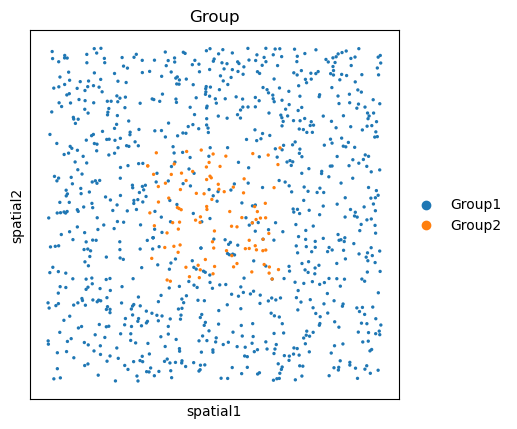

In [76]:
sim_adata.obsm['spatial'] = points
sc.pl.spatial(sim_adata, color='Group', spot_size=0.01)

In [77]:
sim_adata.write_h5ad('/home/DingchengYi/BulkPheno/data/Simulation/sim2_1b.h5ad')